# Noise reduction + wavelet transform

**In this notebook, I decompose the signals using a Wavelet Transform (WT) from which entropy measures are computed and stored in a dataframe**

Inspired from a Kaggle notebook -> https://www.kaggle.com/kiran3799/epilepsy-prediction-notebook

and from a paper -> https://journals.sagepub.com/doi/10.1177/1550147720911009

## Overall process

From each segments:

* Noise reduction using ICA algorithm (fastICA from sklearn)
* Wavelet transform
* Features extraction (mean absolute value, average power, standard deviation, variance, mean, skewness, and Shannon entropy)
* Classification (KNN, SVM, ...)

## Test wavelet.py

In [10]:
%load_ext autoreload
%autoreload 2

import os
import sys
nb_dir = os.path.join(os.getcwd(), '..')
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from SafeSeizure import wavelet_utils, wavelet

In [17]:
X_train_scaled, y_train, X_test_scaled, y_test = wavelet.get_scaled_split_data()

1046 1046
Retrieved X, y successfully


In [18]:
X_train_scaled.shape

(732, 720)

## Logistic regression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

log_reg = LogisticRegression()
sm = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = sm.fit_resample(X_test, y_test)
X_resampled, y_resampled = sm.fit_resample(X, y)

cv_results = cross_validate(log_reg, X_resampled, y_resampled, cv=5,
                            scoring=['recall','accuracy', 'f1', 'precision'])
cv_results

{'fit_time': array([0.41244388, 0.41708398, 0.41623092, 0.44047379, 0.424613  ]),
 'score_time': array([0.00763106, 0.00906587, 0.00824809, 0.00870419, 0.00850487]),
 'test_recall': array([0.85306122, 0.86122449, 0.85986395, 0.86239782, 0.8829932 ]),
 'test_accuracy': array([0.72993197, 0.77823129, 0.79047619, 0.71477195, 0.72906739]),
 'test_f1': array([0.75953967, 0.79522613, 0.80407125, 0.75133531, 0.76533019]),
 'test_precision': array([0.68449782, 0.7386231 , 0.75507766, 0.66561514, 0.67533819])}

In [40]:
log_reg.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [13]:
log_reg.score(X_test_resampled, y_test_resampled)

0.5703266787658802

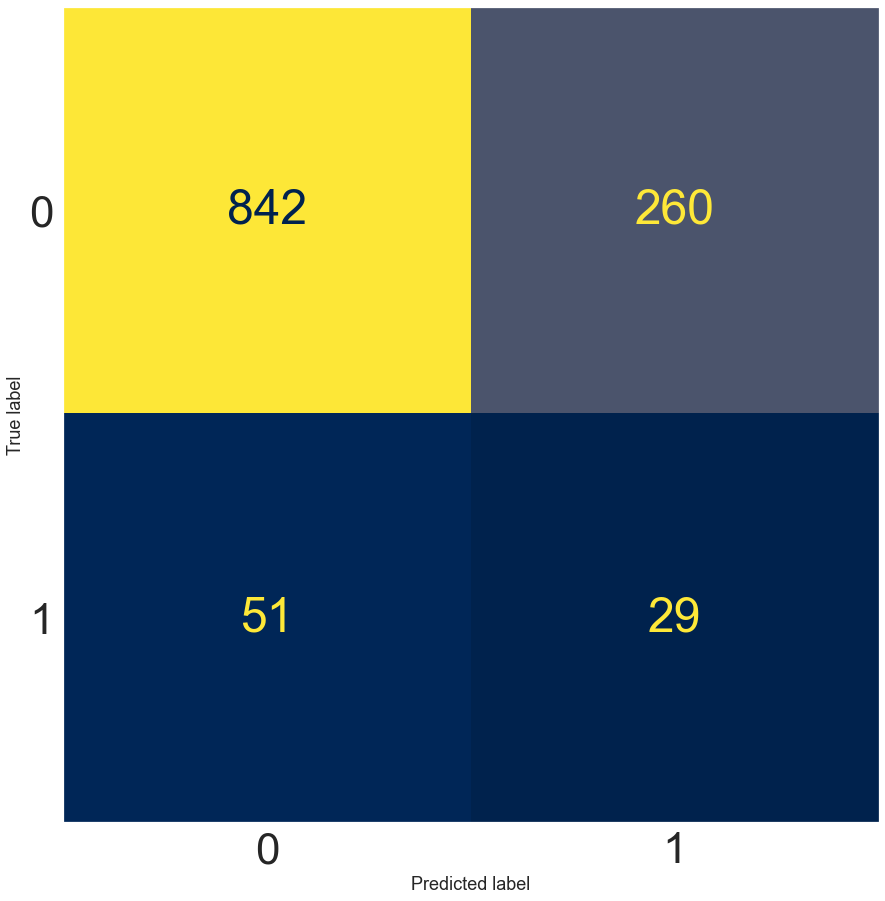

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.grid(False)
sns.set(font_scale=4.0)
label_font = {'size':'18'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

plot_confusion_matrix(log_reg, X_test, y_test, ax=ax, cmap='cividis', colorbar=False);

plt.savefig('confusion_matrix_log_reg.png', bbox_inches='tight')
plt.show()

## Support Vector Machines

### Linear kernel

In [17]:
from sklearn.svm import SVC

svc_linear = SVC(kernel='linear')
cv_results = cross_validate(svc_linear, X_train_resampled, y_train_resampled, cv=5, scoring=['recall',
                                                                                 'accuracy', 'f1', 'precision'])
cv_results

{'fit_time': array([6.63205814, 6.14326978, 5.82949924, 5.95680618, 6.17880917]),
 'score_time': array([0.27371812, 0.26498818, 0.2675209 , 0.260077  , 0.27334499]),
 'test_recall': array([0.93579767, 0.96498054, 0.95339806, 0.95145631, 0.95525292]),
 'test_accuracy': array([0.84645287, 0.86005831, 0.84548105, 0.86686103, 0.84241245]),
 'test_f1': array([0.85892857, 0.87323944, 0.86064855, 0.87735004, 0.85839161]),
 'test_precision': array([0.79372937, 0.79742765, 0.78434505, 0.81395349, 0.77936508])}

In [18]:
svc_linear.fit(X_train_resampled, y_train_resampled)

SVC(kernel='linear')

In [19]:
svc_linear.score(X_test_resampled, y_test_resampled)

0.5852994555353902

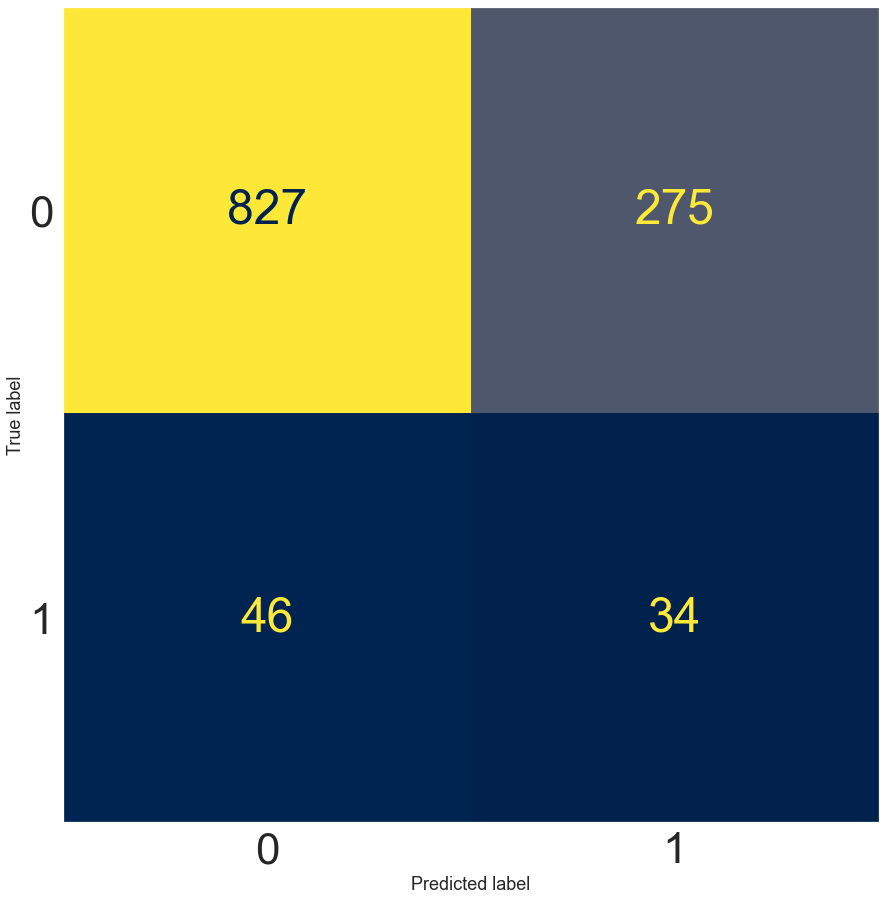

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.grid(False)
sns.set(font_scale=4.0)
label_font = {'size':'18'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

plot_confusion_matrix(svc_linear, X_test, y_test, ax=ax, cmap='cividis', colorbar=False);

plt.savefig('confusion_matrix_svc_linear.png', bbox_inches='tight')
plt.show()

### Polynomial kernel

In [21]:
svc_poly = SVC(kernel='poly')
cv_results = cross_validate(svc_poly, X_train_resampled, y_train_resampled, cv=5, scoring=['recall',
                                                                               'accuracy', 'f1', 'precision'])
cv_results

{'fit_time': array([3.04140806, 2.80035782, 2.72209215, 2.86658907, 2.79489398]),
 'score_time': array([0.37700701, 0.27679801, 0.30675793, 0.28303194, 0.29281497]),
 'test_recall': array([1.        , 1.        , 1.        , 1.        , 0.99416342]),
 'test_accuracy': array([0.97473275, 0.97376093, 0.96598639, 0.97084548, 0.96692607]),
 'test_f1': array([0.97533207, 0.97440758, 0.96713615, 0.97169811, 0.96780303]),
 'test_precision': array([0.95185185, 0.95009242, 0.93636364, 0.94495413, 0.94280443])}

In [22]:
svc_poly.fit(X_train_resampled, y_train_resampled)

SVC(kernel='poly')

In [23]:
svc_poly.score(X_test_resampled, y_test_resampled)

0.5526315789473685

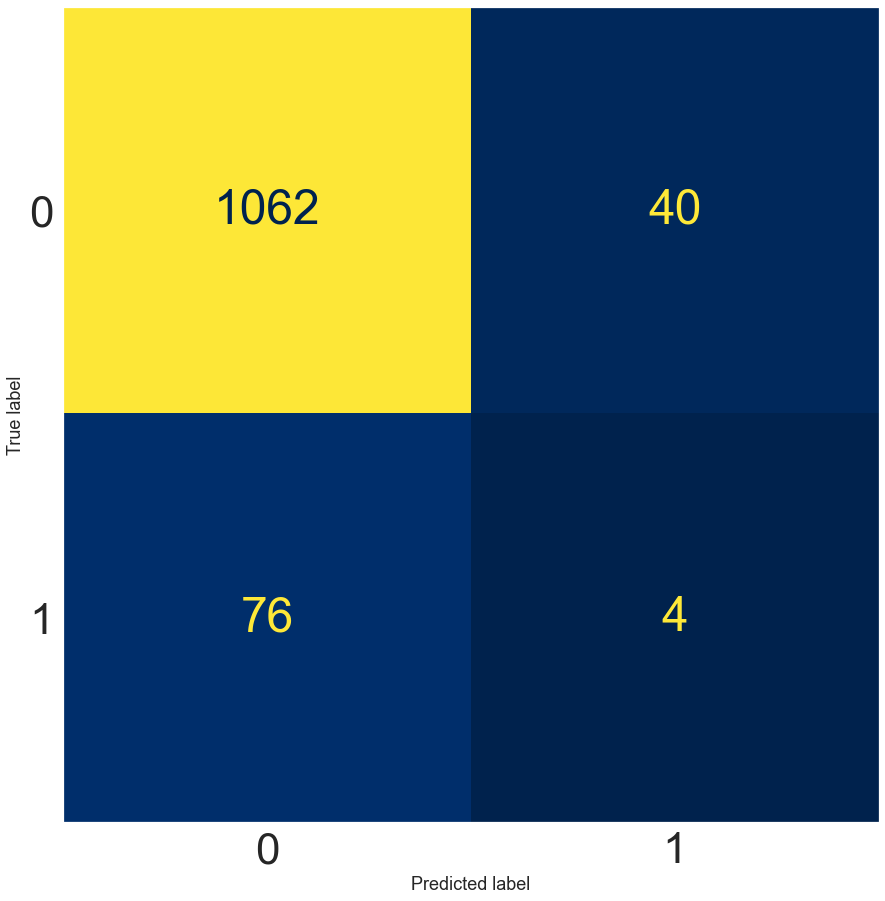

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.grid(False)
sns.set(font_scale=4.0)
label_font = {'size':'18'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

plot_confusion_matrix(svc_poly, X_test, y_test, ax=ax, cmap='cividis', colorbar=False);

plt.savefig('confusion_matrix_svc_poly.png', bbox_inches='tight')
plt.show()

## KNeighbors Classifier

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

cv_results = cross_validate(knn, X_resampled, y_resampled, cv=5, scoring=['recall', 
                                                                          'accuracy', 'f1', 'precision'])
cv_results

{'fit_time': array([0.01553798, 0.00876284, 0.00842285, 0.00863576, 0.00830889]),
 'score_time': array([0.22032189, 0.15399623, 0.151649  , 0.1524961 , 0.15115404]),
 'test_recall': array([1., 1., 1., 1., 1.]),
 'test_accuracy': array([0.67619048, 0.70408163, 0.69251701, 0.6691627 , 0.66712049]),
 'test_f1': array([0.75539568, 0.77165354, 0.7648283 , 0.75127943, 0.75038285]),
 'test_precision': array([0.60693642, 0.62820513, 0.61920809, 0.60163934, 0.6004902 ])}

In [45]:
knn.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(n_neighbors=3)

In [46]:
knn.score(X_test_resampled, y_test_resampled)

0.6234119782214156

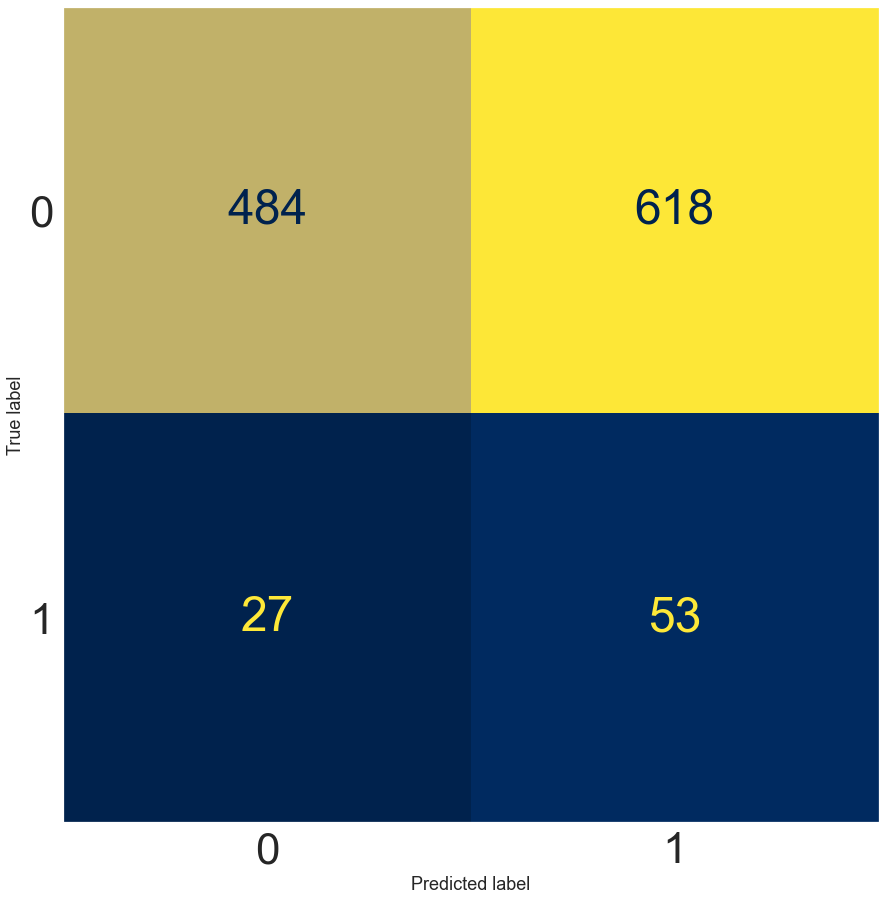

In [47]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.grid(False)
sns.set(font_scale=4.0)
label_font = {'size':'18'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

plot_confusion_matrix(knn, X_test, y_test, ax=ax, cmap='cividis', colorbar=False);

plt.savefig('confusion_matrix_knn.png', bbox_inches='tight')
plt.show()

## Ensemble classifiers

In [48]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=50, class_weight='balanced')

cv_results = cross_validate(random_forest, X_resampled, y_resampled, cv=5, scoring=['recall',
                                                                'accuracy', 'f1', 'precision'])
cv_results

{'fit_time': array([3.93150091, 3.562953  , 3.55858803, 3.60389996, 3.86152101]),
 'score_time': array([0.01615   , 0.01845503, 0.01651502, 0.01639986, 0.01755905]),
 'test_recall': array([0.83129252, 1.        , 1.        , 1.        , 1.        ]),
 'test_accuracy': array([0.91496599, 0.99863946, 1.        , 0.99455412, 0.99319265]),
 'test_f1': array([0.90720119, 0.9986413 , 1.        , 0.99457995, 0.99324324]),
 'test_precision': array([0.99836601, 0.9972863 , 1.        , 0.98921833, 0.98657718])}

In [49]:
random_forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', n_estimators=50)

In [53]:
random_forest.score(X_test_resampled, y_test_resampled)

0.7885662431941923

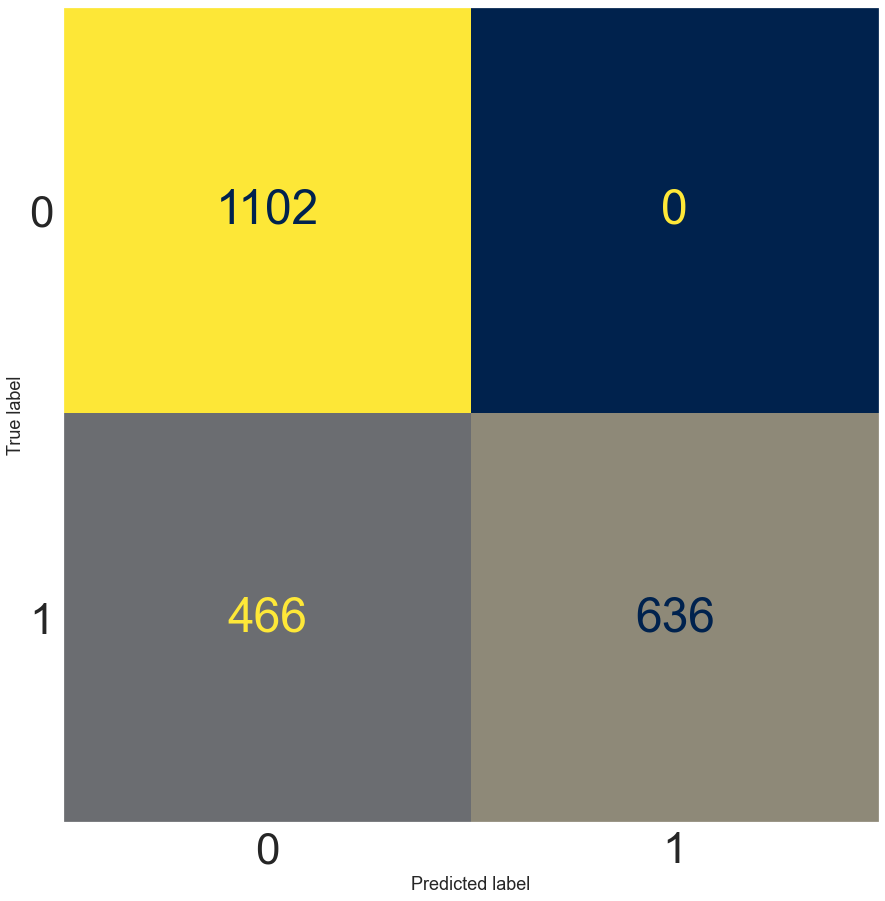

In [52]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.grid(False)
sns.set(font_scale=4.0)
label_font = {'size':'18'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

plot_confusion_matrix(random_forest, X_test_resampled, y_test_resampled, ax=ax, cmap='cividis', colorbar=False);

plt.savefig('confusion_matrix_random_forest.png', bbox_inches='tight')
plt.show()